In [1]:
import pandas as pd
import numpy as np 
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
#stemmer=PorterStemmer()

In [2]:
#!pip install contractions
import contractions

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
df = pd.read_csv('train.csv')#'/content/drive/MyDrive/ml project/train.csv')
#df_ = pd.read_csv('/content/drive/MyDrive/ml project/data.csv')

In [5]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /home/bharat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def preprocess1(a):
    x=a.lower()#convert to lower case
    x=contractions.fix(x)#contraction, eg. I'll -> I will
    x= x.encode("ascii", "ignore").decode() # non ascii chars
    x = re.sub(r'\s+[a-zA-Z]\s+', ' ', x) # single characters 
    x = re.sub(r'\^[a-zA-Z]\s+', ' ', x) # single char at first
    #x = re.sub(r'[0-9]', ' ', x) # digit
    x=re.findall(r"\w+",x)
    return x

In [7]:
def preprocess2(a):
    x=[stemmer.stem(i) for i in a if i not in stop_words]
    return ' '.join(x)

In [8]:
def preprocess(text):
    return preprocess2(preprocess1(text))

In [9]:
def data_processing(df):
    main = df[df['title'].notna()]
    main['author'].fillna('unknown', inplace=True)
    return main

In [10]:
def data_plot(main):
    print(main['label'].value_counts())
    main['label'].value_counts().plot(kind='pie', title='Label Counts Percentage', autopct='%1.2f%%')
    plt.show()

In [11]:
def final_data(main):
    return (main['title'] + ' ' + main['author']).apply(preprocess)

In [12]:
def x_y_train(X,main):
    train_x = TfidfVectorizer().fit_transform(list(X))
    train_y=list(main.label)
    return train_x,train_y

In [13]:
def x_y_data(df):  
    main=data_processing(df)
    X=final_data(main)
    return x_y_train(X,main),main

In [14]:
[X,Y],main=x_y_data(df)
train_x,test_x, train_y, test_y = train_test_split(X, Y,test_size=0.2)
#len(train_x), len(test_x)

/home/bharat/.local/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [15]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [16]:
main.isnull().sum() 

id         0
title      0
author     0
text      39
label      0
dtype: int64

0    10387
1     9855
Name: label, dtype: int64


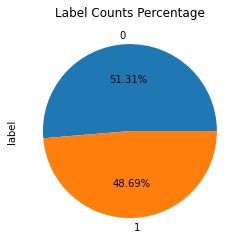

In [17]:
data_plot(main)

In [18]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB,CategoricalNB
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC

In [19]:
from pickle import load,dump
import os

In [20]:
def save_model(model,name):
    try:
        os.mkdir("models")
    except:
        print()
        
    dump(model,open("models/"+name,"wb+",))
    try:
        save_coef(model)
    except:
        print("no coef")

In [21]:
def read_model(name):
    return load(open("models/"+name,"rb"))

In [22]:
def save_coef(model):
    if model.coef_ is False:
        return
    try:
        os.mkdir("coefs")
    except:
        print()
    
    f=open("coefs/"+str(model)+"_coef","ab+")
    dump(model.coef_,f)
    f.close()

In [44]:
def calculate_for_train(Model,train_x,train_y):
    model=Model.fit(train_x,train_y)
    y_pred = model.predict(train_x)

    
    print(f"Accuracy : {accuracy_score(train_y, y_pred)}")
    print(f"F1-Score : {f1_score(train_y, y_pred)}")

    try:
        plot_confusion_matrix(model, train_x, train_y, display_labels=['Reliable', 'Unreliable'])
        plt.show()
    except:
        print("no confusion matrix")
    return model


In [24]:
def calculate_for_testing(model,train_x,train_y):
    y_pred = model.predict(train_x)
    print(f"Accuracy : {accuracy_score(train_y, y_pred)}")
    print(f"F1-Score : {f1_score(train_y, y_pred)}")

    plot_confusion_matrix(model, train_x, train_y, display_labels=['Reliable', 'Unreliable'])
    plt.show()
    

Accuracy : 0.9964182053973939
F1-Score : 0.9963193298641959


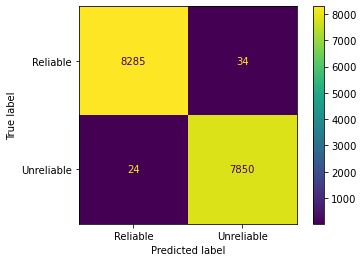


no coef


In [45]:
model_SVC=calculate_for_train(SVC(kernel="sigmoid"),train_x,train_y)
save_model(model_SVC,"svm")

Accuracy : 0.9920968140281551
F1-Score : 0.9919436052366566


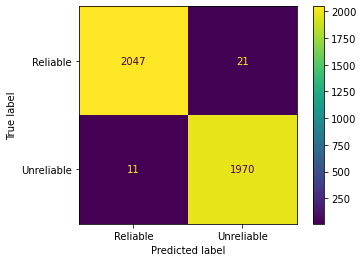

In [46]:
calculate_for_testing(model_SVC,test_x,test_y)

Accuracy : 0.9560303834990428
F1-Score : 0.9556993529118964


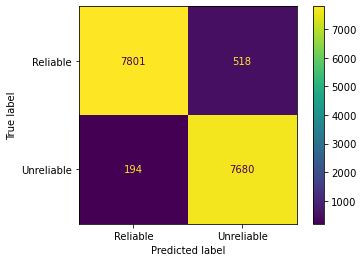


no coef


In [25]:
model_KNeighborsClassifier=calculate_for_train(KNeighborsClassifier(n_neighbors=130),train_x,train_y)
save_model(model_KNeighborsClassifier,"knn")

Accuracy : 0.9478883674981476
F1-Score : 0.9483223120254715


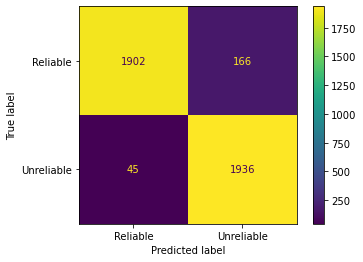

In [26]:
calculate_for_testing(read_model("knn"),test_x,test_y)

Accuracy : 1.0
F1-Score : 1.0


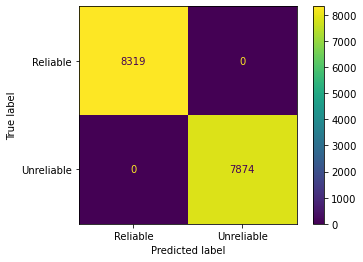


no coef


In [27]:

model_dt_gini=calculate_for_train(DecisionTreeClassifier(criterion='gini'),train_x,train_y)
save_model(model_dt_gini,"dt_gini")

Accuracy : 0.9920968140281551
F1-Score : 0.9919273461150353


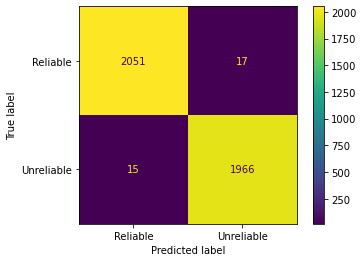

In [28]:
calculate_for_testing(read_model("dt_gini"),test_x,test_y)

Accuracy : 1.0
F1-Score : 1.0


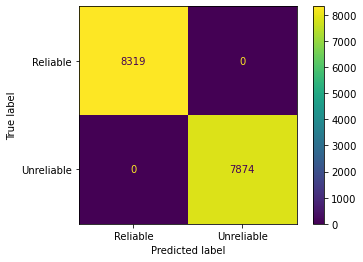


no coef


In [29]:

model_dt_entropy=calculate_for_train(DecisionTreeClassifier(criterion='entropy'),train_x,train_y)
save_model(model_dt_entropy,"dt_entropy")

Accuracy : 0.9925907631513954
F1-Score : 0.9924395161290323


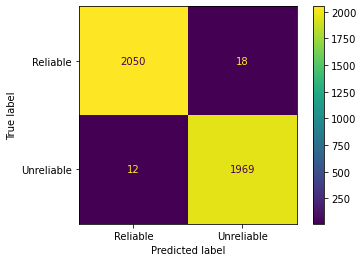

In [30]:
calculate_for_testing(read_model("dt_entropy"),test_x,test_y)

Accuracy : 1.0
F1-Score : 1.0


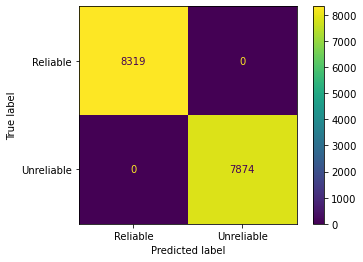


no coef


In [31]:

model_rf_gini=calculate_for_train(RandomForestClassifier(criterion='gini'),train_x,train_y)
save_model(model_rf_gini,"rf_gini")

Accuracy : 0.988639170165473
F1-Score : 0.9884538152610443


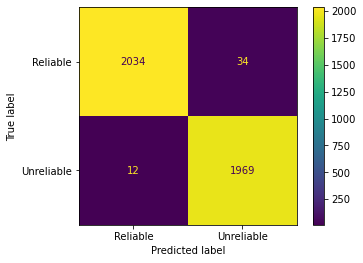

In [32]:
calculate_for_testing(read_model("rf_gini"),test_x,test_y)

Accuracy : 1.0
F1-Score : 1.0


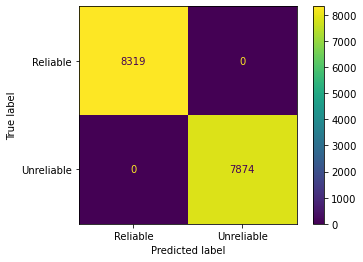


no coef


In [33]:

model_rf_entropy=calculate_for_train(RandomForestClassifier(criterion='entropy'),train_x,train_y)
save_model(model_rf_entropy,"rf_entropy")

Accuracy : 0.9896270684119536
F1-Score : 0.9894578313253013


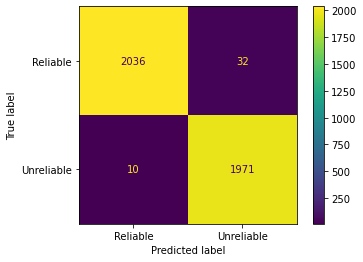

In [34]:
calculate_for_testing(read_model("rf_entropy"),test_x,test_y)

Accuracy : 0.9903044525412216
F1-Score : 0.9900865062827556


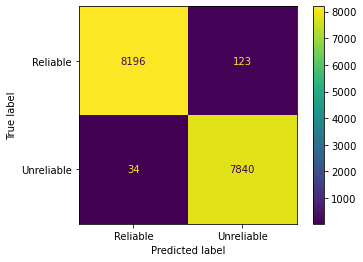

In [35]:
model_LogisticRegression=calculate_for_train(LogisticRegression(),train_x,train_y)
save_model(model_LogisticRegression,"log_reg")

Accuracy : 0.9787601877006669
F1-Score : 0.9786176031824962


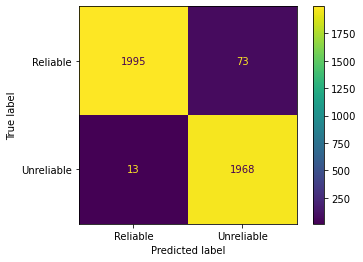

In [36]:
calculate_for_testing(read_model("log_reg"),test_x,test_y)

Accuracy : 0.9333045142963009
F1-Score : 0.9263904034896402


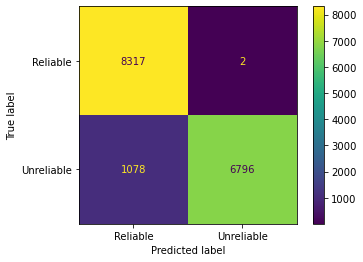


no coef


In [37]:
model_GaussianNB=calculate_for_train(GaussianNB(),train_x.toarray(),train_y)
save_model(model_GaussianNB,"g_nb")

Accuracy : 0.8202025191405286
F1-Score : 0.7956204379562044


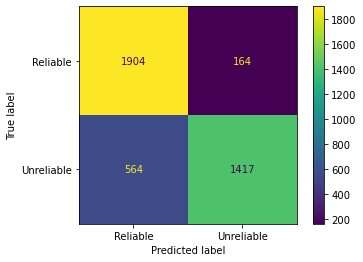

In [38]:
calculate_for_testing(read_model("g_nb"),test_x.toarray(),test_y)

Accuracy : 0.982832087939233
F1-Score : 0.9820668300864405


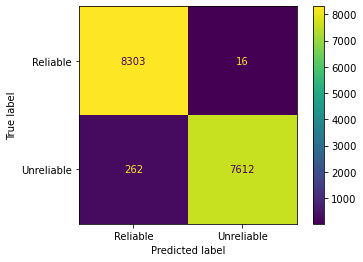

/home/bharat/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [39]:
model_MultinomialNB=calculate_for_train(MultinomialNB(),train_x,train_y)
save_model(model_MultinomialNB,"m_nb")

Accuracy : 0.9636947394418375
F1-Score : 0.9616688396349413


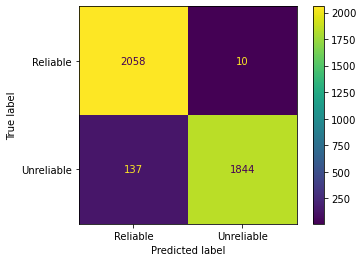

In [40]:
calculate_for_testing(read_model("m_nb"),test_x,test_y)

Accuracy : 0.992218860001235
F1-Score : 0.9920040614291153


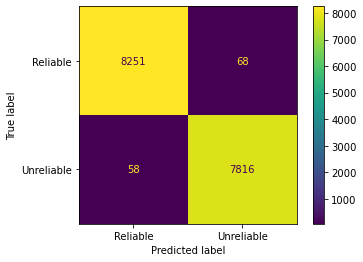

/home/bharat/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [41]:
model_BernoulliNB=calculate_for_train(BernoulliNB(),train_x,train_y)
save_model(model_BernoulliNB,"b_nb")

Accuracy : 0.9814769078784885
F1-Score : 0.981151042975622


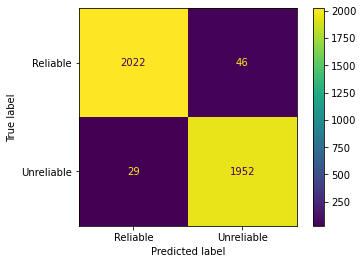

In [42]:
calculate_for_testing(read_model("b_nb"),test_x,test_y)

Accuracy : 0.992218860001235
F1-Score : 0.9920040614291153


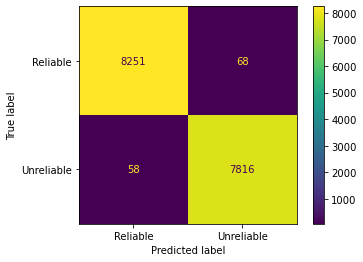

/home/bharat/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [43]:
model_=calculate_for_train(BernoulliNB(),train_x,train_y)
save_model(model_BernoulliNB,"b_nb")